In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Data Pre-Processing and Augmentation using Keras ImageDataGenerator

In [ ]:
import tensorflow as tf 

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                          rotation_range = 8, 
                                                          width_shift_range = 0.1, 
                                                          height_shift_range = 0.1,
                                                          shear_range = 0.2, 
                                                          zoom_range = 0.2,
                                                          brightness_range = [0.5,1.5],
                                                          horizontal_flip = True,
                                                          fill_mode = 'nearest',
                                                          dtype = None,                                                      
                                                          validation_split = 0.075)

Defining generators for training and validation set

In [ ]:
dire = '/content/gdrive/MyDrive/Eye Diseases'

train_generator = datagen.flow_from_directory(
    dire,
    subset="training",
    batch_size=32,
    class_mode='categorical',     
    shuffle=True,                      
    target_size=(200,200)
)

valid_generator = datagen.flow_from_directory(
    dire,
    subset="validation",
    shuffle=True,
    batch_size=32,
    class_mode='categorical',                           
    target_size=(200,200)
)

In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

Deducing and saving labels

In [ ]:
label_batch[0:5]
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

{'Arcus Senilis': 0, 'Cataracts': 1, 'Endophthalmitis': 2, 'Hemangioma': 3, 'Hyphema': 4}
Arcus Senilis
Cataracts
Endophthalmitis
Hemangioma
Hyphema

Retrieving vgg16 pretrained vgg weights

In [ ]:
import os
import urllib.request

urllib.request.urlretrieve('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                           'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
os.listdir()

['.config',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'gdrive',
 'labels.txt',
 'sample_data']

Initializing vgg model with downloaded, pretrained weights and input shape of 200,200,3 because of the small image size in the dataset

In [ ]:
from tensorflow.keras import layers 
from tensorflow.keras import Model 

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

from keras.applications.vgg16 import VGG16, preprocess_input

vgg16_weight_path = '/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

vgg = VGG16(
    weights = vgg16_weight_path,
    include_top = False, 
    input_shape = (200,200,3)
)

Freezing previous layers 

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

##Adding layers for training 

best accuracy: 128 -> 32 -> 5 for final activation

In [ ]:
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import regularizers



model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))
#model.add(Dense(16, activation='relu'))
#model.add(layers.Dropout(rate=0.1))
model.add(Dense(5,activation="softmax"))

Slow learning rate with larger number of epochs has proven to give more accurate results without overfitting

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                

Training for first 300 epochs

In [ ]:
hist= model.fit(train_generator, validation_data = valid_generator, epochs = 300)

Epoch 1/300
33/33 [==============================] - 19s 521ms/step - loss: 1.7537 - accuracy: 0.2769 - val_loss: 1.4515 - val_accuracy: 0.4096
Epoch 2/300
33/33 [==============================] - 15s 461ms/step - loss: 1.4878 - accuracy: 0.3669 - val_loss: 1.3629 - val_accuracy: 0.5301
Epoch 3/300
33/33 [==============================] - 15s 463ms/step - loss: 1.3833 - accuracy: 0.4446 - val_loss: 1.3419 - val_accuracy: 0.4699
Epoch 4/300
33/33 [==============================] - 15s 463ms/step - loss: 1.4016 - accuracy: 0.3915 - val_loss: 1.2581 - val_accuracy: 0.5060
Epoch 5/300
33/33 [==============================] - 15s 460ms/step - loss: 1.3530 - accuracy: 0.4132 - val_loss: 1.2836 - val_accuracy: 0.5301
Epoch 6/300
33/33 [==============================] - 15s 462ms/step - loss: 1.3432 - accuracy: 0.4480 - val_loss: 1.2664 - val_accuracy: 0.4578
Epoch 7/300
33/33 [==============================] - 15s 461ms/step - loss: 1.3387 - accuracy: 0.4464 - val_loss: 1.2287 - val_accuracy:

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

3/3 [==============================] - 1s 380ms/step - loss: 0.5991 - accuracy: 0.7952
Final loss: 0.60
Final accuracy: 79.52%


In [ ]:
hist= model.fit(train_generator, validation_data = valid_generator, epochs = 300)

Epoch 1/300
33/33 [==============================] - 16s 477ms/step - loss: 0.2361 - accuracy: 0.9148 - val_loss: 0.5991 - val_accuracy: 0.7952
Epoch 2/300
33/33 [==============================] - 15s 457ms/step - loss: 0.2481 - accuracy: 0.9053 - val_loss: 0.7662 - val_accuracy: 0.7470
Epoch 3/300
33/33 [==============================] - 15s 459ms/step - loss: 0.2838 - accuracy: 0.8890 - val_loss: 0.8643 - val_accuracy: 0.7952
Epoch 4/300
33/33 [==============================] - 15s 461ms/step - loss: 0.2541 - accuracy: 0.9062 - val_loss: 0.6146 - val_accuracy: 0.8193
Epoch 5/300
33/33 [==============================] - 15s 459ms/step - loss: 0.2338 - accuracy: 0.9234 - val_loss: 0.5626 - val_accuracy: 0.8434
Epoch 6/300
33/33 [==============================] - 15s 464ms/step - loss: 0.2751 - accuracy: 0.9053 - val_loss: 0.6870 - val_accuracy: 0.7831
Epoch 7/300
33/33 [==============================] - 15s 459ms/step - loss: 0.2584 - accuracy: 0.9100 - val_loss: 0.6547 - val_accuracy:

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator)
print("Final loss: {:.2f}".format(final_loss))
print("Final Valid accuracy: {:.2f}%".format(final_accuracy * 100))

final_loss, final_accuracy = model.evaluate(train_generator)
print("Final loss: {:.2f}".format(final_loss))
print("Final Train accuracy: {:.2f}%".format(final_accuracy * 100))

3/3 [==============================] - 1s 473ms/step - loss: 0.7212 - accuracy: 0.8193
Final loss: 0.72
Final Valid accuracy: 81.93%
33/33 [==============================] - 14s 414ms/step - loss: 0.0791 - accuracy: 0.9761
Final loss: 0.08
Final Train accuracy: 97.61%


In [ ]:
model.save('/content/gdrive/MyDrive/Eye Diseases/eye_disease_detection.h5')

In [ ]:
import numpy as np

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 200, 200, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Arcus Senilis' 'Cataracts' 'Endophthalmitis' 'Hemangioma' 'Hyphema']


Predicting on validation set

In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)
print(tf_model_predictions)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

Prediction results shape: (32, 5)
[[5.30476719e-02 9.45869148e-01 7.01819663e-05 4.88160003e-05
  9.64164559e-04]
 [1.00943704e-04 9.99897122e-01 8.11278227e-08 1.24229132e-07
  1.70897761e-06]
 [1.02753507e-03 6.63300161e-05 9.81068671e-01 2.44020222e-04
  1.75935514e-02]
 [5.15712500e-02 7.63550282e-01 8.00942816e-03 4.22490615e-04
  1.76446497e-01]
 [1.75755355e-04 3.66787463e-05 7.14716196e-01 1.18185075e-04
  2.84953296e-01]
 [5.64435720e-01 1.77410850e-03 2.13300407e-01 6.23232918e-03
  2.14257389e-01]
 [1.40494012e-04 4.08467276e-05 1.41212333e-03 8.69257492e-04
  9.97537255e-01]
 [1.11508009e-03 5.07826335e-05 8.39429922e-05 9.98690069e-01
  6.01527354e-05]
 [1.15322627e-01 3.46851423e-02 6.20426536e-02 9.29986127e-03
  7.78649688e-01]
 [5.74010483e-04 4.90027560e-05 4.97739129e-05 5.78649851e-05
  9.99269307e-01]
 [9.83977854e-01 1.51552129e-04 1.57604776e-02 1.13339902e-05
  9.87565145e-05]
 [1.01009607e-02 9.84148264e-01 4.15319623e-03 8.09078992e-05
  1.51675765e-03]
 [2.75

Validation Set Prediction Results: 

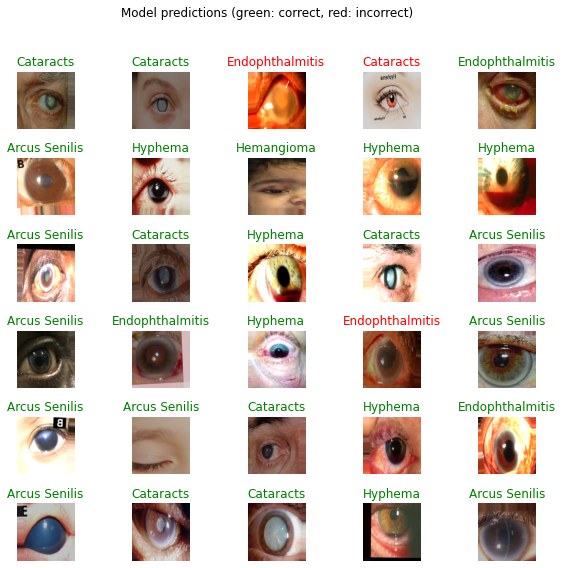

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Model Testing

In [ ]:
from keras.preprocessing.image import load_img
 
image = load_img('/content/gdrive/MyDrive/Eye Diseases/Test Images/_185_capillaryhemangioma1.jpg', target_size=(200,200))


In [ ]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)
#image = np.repeat(image, 3, 2)

In [ ]:
image = np.expand_dims(image,axis=0)
image = np.array(image)/255.0
print(image.shape)

(1, 200, 200, 3)


In [ ]:
pred = model.predict(image)
print(pred.shape)
print (pred)

(1, 5)
[[0.2072205  0.00075663 0.03469858 0.71819454 0.03912976]]


In [ ]:
predicted_id = np.argmax(pred, axis=-1)
predicted_labels = dataset_labels[predicted_id]
print(predicted_labels)

['Hemangioma']
